In [1]:
import pandas as pd
import numpy as np
import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import LatentDirichletAllocation

import scipy.sparse
from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages')
from xgboost.sklearn import XGBClassifier

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Reading relevant files

In [2]:
ipb = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/ipblocks_fulldump_20190223.txt", sep ='\t')
#ipb = pd.read_csv("ipblocks_fulldump.csv")
ipb = ipb[['ipb_address','date']]
ipb.rename(columns = {'ipb_address':"username",'date':'bl_date'}, inplace=True)
ipb.bl_date = ipb.bl_date.astype('str')
ipb.bl_date = pd.to_datetime(ipb.bl_date)
ipb['ipb_bl'] = 1
print(len(ipb))
ipb.head()

1166572


,username,bl_date,ipb_bl
0,Wanli2,2004-02-08,1
1,Xuepiao,2004-02-08,1
2,GrandVoivodOfErdely,2004-02-08,1
3,#1703,2004-02-13,1
4,Wanli3,2004-03-14,1


In [3]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Blocked/*.csv')
d2=pd.DataFrame()
for file in files:
    d2s = pd.read_csv(file)
    d2 = pd.concat([d2,d2s])
print(d2.shape)
d2.dates = d2.dates.astype('str')
d2.dates = pd.to_datetime(d2.dates).dt.date
d2.dates = pd.to_datetime(d2.dates)
d2.drop(columns=['Unnamed: 0'], inplace=True)
d2.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d2['bl'] = 1
d2 = d2[~d2.char_changes.str.contains('-')]
print(d2.shape)
d2.tail()

(124102, 6)
(99761, 6)


,char_changes,revision_date,links,username,text,bl
32362,+420,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,:PROD = proposed deletion (anyone can challeng...,1
32363,+171,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::::::thanks, I think you will know who I am ...",1
32364,+924,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,"::::::{{reply to|Alexanderlee}}, no problems, ...",1
32365,+46,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::{{reply to|Snowflake91|Chrissymad}}Good, ac...",1
32366,+571,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::: I know, I am now exactly talking about so...",1


In [4]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Non_Blocked/*.csv')
d3=pd.DataFrame()
for file in files:
    d3s = pd.read_csv(file)
    d3 = pd.concat([d3,d3s])
print(d3.shape)
d3.dates = d3.dates.astype('str')
d3.dates = pd.to_datetime(d3.dates).dt.date
d3.dates = pd.to_datetime(d3.dates)
d3.drop(columns=['Unnamed: 0'], inplace=True)
d3.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d3['bl'] = 0
d3 = d3[~d3.char_changes.str.contains('-')]
print(d3.shape)
d3.tail()

(257082, 6)
(219751, 6)


,char_changes,revision_date,links,username,text,bl
41479,0,2018-08-07,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41480,0,2018-07-30,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41481,0,2018-04-09,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41482,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41483,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0


In [5]:
d4 = pd.concat([d2,d3])
print(len(d4))
print(d4.bl.value_counts())
d4.head(10)

319512
0    219751
1     99761
Name: bl, dtype: int64


,char_changes,revision_date,links,username,text,bl
0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
6,"+1,800",2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
7,+130,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),":Hello, can I still edit my page? [[User:(127....",1
8,+414,2018-05-22,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:Hi Guy. I don't know why you are accusing me ...,1
9,+110,2012-03-10,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::::Thanks! [[User:(127.0.0.1)|(127.0.0.1)]] ...,1
10,+580,2012-03-09,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::The first source ''usatoday'' is already re...,1


In [6]:
d4.reset_index(inplace=True)
d4.head()

,index,char_changes,revision_date,links,username,text,bl
0,0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
4,5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1


In [7]:
a1 = pd.DataFrame(d4.links.str.extractall(r'(&oldid=)([\d]*)')[1])
a1.reset_index(inplace=True)
d4['rev_id'] = a1[1]
d4.head()

,index,char_changes,revision_date,links,username,text,bl,rev_id
0,0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1,821350201
1,1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1,831073982
2,2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1,831059743
3,3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1,831059095
4,5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1,842665329


In [8]:
print(d4.shape)
d4.rev_id.nunique()

(319512, 8)


319512

### Corpus Creation

In [9]:
db = d4.sort_values(['username','revision_date','bl'],ascending = [True, False,False])
db.reset_index(inplace=True)
db.drop(['index','links','level_0'],axis=1,inplace=True)
db['occurance'] = db.sort_values(['username','revision_date','bl'], ascending = False).groupby('username').cumcount() + 1
db.head(10)

,char_changes,revision_date,username,text,bl,rev_id,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5
5,+289,2015-08-27,! Bikkit !,::Thank you for your answer! And thanks for th...,0,678070719,6
6,+727,2015-08-26,! Bikkit !,== Pentagonal tiling: Colors of sides (Reinhar...,0,677901471,7
7,+122,2018-01-09,!MNc99,== Genre ==Can I suggest we change the genre o...,0,819463253,1
8,+126,2012-07-23,!MNc99,'''I'm not interested in talking with you.''' ...,0,503814758,2
9,+107,2012-07-23,!MNc99,== Oh In Colour ==Thanks for your continued ex...,0,503812045,3


In [10]:
dbm = pd.merge(db,ipb,left_on='username',right_on='username',how="left")
print(dbm.bl.value_counts())
print(dbm.ipb_bl.value_counts())
dbm.drop(['ipb_bl'], axis=1,inplace=True)
dbm.head()

0    219751
1     99761
Name: bl, dtype: int64
1.0    98128
Name: ipb_bl, dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,NaT
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,NaT
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,NaT
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,NaT
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,NaT


In [11]:
print(dbm.isna().sum())
dbm.bl_date.fillna('2019-01-01',inplace=True)
dbm.dropna(inplace=True)
print(dbm.isna().sum())
dbm.bl_date = pd.to_datetime(dbm.bl_date)
dbm.head()

char_changes          0
revision_date         0
username              0
text              16832
bl                    0
rev_id                0
occurance             0
bl_date          221384
dtype: int64
char_changes     0
revision_date    0
username         0
text             0
bl               0
rev_id           0
occurance        0
bl_date          0
dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


         mean  max
bl                
0   10.879664   40
1    5.785332   40


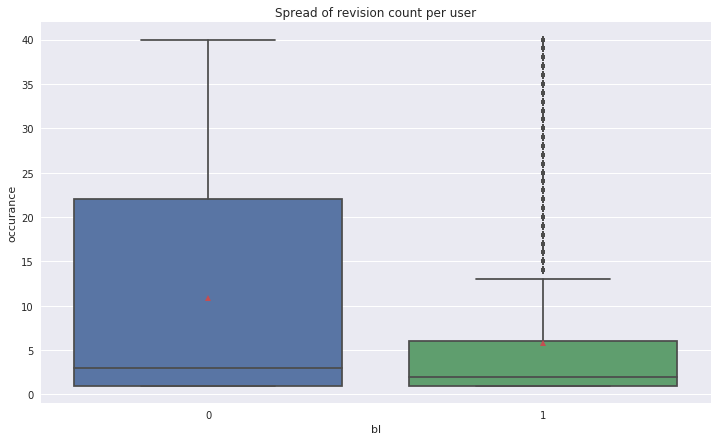

In [12]:
plt1 = pd.DataFrame(dbm.groupby(['username','bl'])['occurance'].agg(lambda x: max(x)))
plt1.reset_index(inplace=True)
print(plt1.groupby('bl')['occurance'].agg({'mean':np.average,'max':max}))
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user')

In [13]:
dbm_cnt = dbm.groupby(['username','bl'])['occurance'].agg({'size1':np.size})
dbm_cnt.reset_index(inplace=True)
print(np.percentile(dbm_cnt[dbm_cnt['bl']==1].size1,[80, 25]))
np.percentile(dbm_cnt[dbm_cnt['bl']==0].size1,[80, 25])
#iqr = np.subtract(*np.percentile(x, [75, 25]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[8. 1.]


array([24.,  1.])

(array([2635., 2200., 2323., 2261., 1998., 1805., 1772., 1704., 1574.,
        1615., 1545., 1656., 1621., 1362., 1343., 1444., 1412., 1504.,
        1801., 1642., 1588., 1492., 1444., 1602., 1501., 1538., 1515.,
        1409., 3046.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

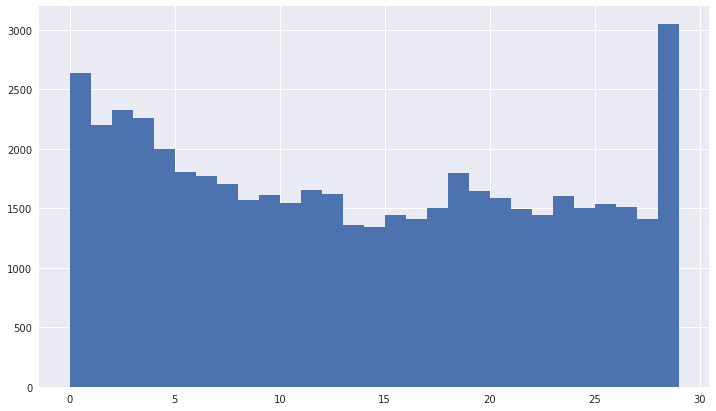

In [14]:
dbm['doi'] = (dbm.bl_date - dbm.revision_date)/7
dbm_b = dbm[dbm['bl']==0]
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_b.doi.dt.days,bins=np.arange(0,30,1))

(array([43253.,  5905.,  3359.,  2723.,  1759.,  1577.,  1366.,  1166.,
          960.,   793.,   670.,   744.,   705.,   546.,   595.,   516.,
          449.,   523.,   397.,   412.,   345.,   423.,   271.,   355.,
          265.,   237.,   250.,   331.,   553.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

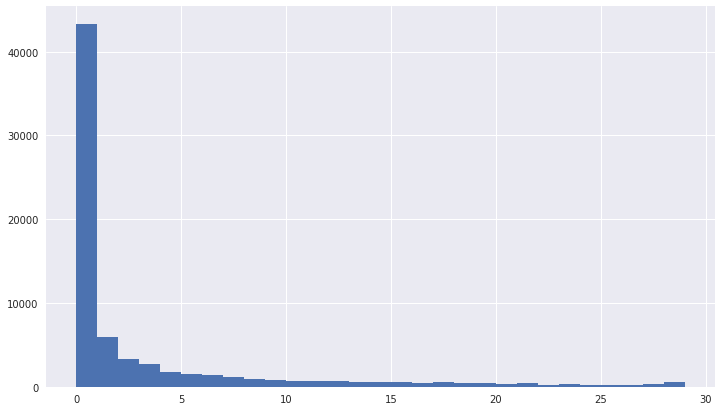

In [15]:
dbm_nb = dbm[dbm['bl']==1]
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_nb.doi.dt.days,bins=np.arange(0,30,1))

In [16]:
#Filtering data for top-10 comments or comments within one week each
dbm['valid_dt'] = 1
print(len(dbm))
dbm.loc[((dbm.bl==1)&(dbm.doi>'7 days')),'valid_dt']=0
dbm = dbm.loc[(dbm.valid_dt==1)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))

302680
266863
Count of Non-Blocked comment 206732 
 Count of Blocked comment 60131


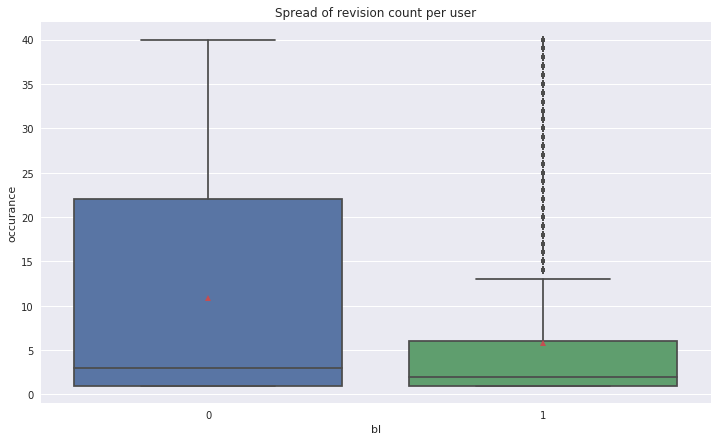

In [17]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user')

In [18]:
dbm = dbm.loc[(dbm.occurance<=10)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))
db.head()

137286
Count of Non-Blocked comment 93441 
 Count of Blocked comment 43845


,char_changes,revision_date,username,text,bl,rev_id,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5


In [19]:
dbm.text = db.text.astype('str')

In [20]:
dbm_all = dbm

### Feature Engineering + Data Cleaning + Train

In [21]:
dbm_all.head()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01,159 days 00:00:00,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01,159 days 03:25:42.857142,1
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01,171 days 10:17:08.571428,1
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1


In [22]:
dbm_all.text = dbm_all.text.str.strip()
dbm_all.text = dbm_all.text.str.replace('(\d{1,2}:\d{1,2}, \d{1,2} [A-Za-z]* \d{1,4} \(UTC)\)'," ")
dbm_all.text = dbm_all.text.str.replace('({{[\w|\W]*?}})'," ")
dbm_all.text = dbm_all.text.str.replace('(\[\[[\w|\W]*?\]\])'," ")
dbm_all.text = dbm_all.text.str.replace('(\{\|[\w|\W]*\|\})'," ")
dbm_all.text = dbm_all.text.str.replace('(<![\w|\W]*?>)'," ")
dbm_all.text = dbm_all.text.str.replace('(<[\w|\W]*?/>)'," ")

In [23]:
dbm_all['clen'] = dbm_all.text.str.len()
dbm_all['numb'] = dbm_all.text.str.count(r'\d')/dbm['clen']
dbm_all['caps'] = dbm_all.text.str.count(r'[A-Z]')/dbm['clen']
dbm_all['caps_ncaps'] = dbm_all.text.str.count(r'[A-Z]')/dbm_all.text.str.count(r'[a-z]')
dbm_all['wordlen'] = dbm_all.text.apply(lambda x: len(str(x).split()))
dbm_all['schar'] = (dbm_all.text.str.count(r'\W')-dbm_all.text.str.count(r'\W\S'))/dbm_all['clen']
dbm_all['unique_wlen_percent']=(dbm_all.text.apply(lambda x: len(set(str(x).split()))))/dbm_all['wordlen']
dbm_all['clen_wlen']=dbm_all['clen']/dbm_all['wordlen']
dbm_all.head()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01,159 days 00:00:00,1,315,0.000000,0.034921,0.051643,62,0.066667,0.790323,5.080645
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1,70,0.000000,0.014286,0.021277,12,0.128571,1.000000,5.833333
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01,159 days 03:25:42.857142,1,551,0.127042,0.110708,0.201987,35,0.039927,0.885714,15.742857
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01,171 days 10:17:08.571428,1,571,0.005254,0.040280,0.055288,78,0.059545,0.807692,7.320513
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1,260,0.023077,0.023077,0.033149,35,0.069231,1.000000,7.428571


In [24]:
dbm_all.text = dbm_all.text.str.replace('(={2,})'," ")
dbm_all.text = dbm_all.text.str.replace('(:{2,})'," ")
dbm_all.text = dbm_all.text.str.replace('(\s{2,})'," ")

In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
#Sentiment analyzer
sentiment_val = dbm_all.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.drop('pos', axis=1,inplace=True)
sent.head()

,neg,neu,compound
0,0.075,0.849,-0.2263
1,0.000,1.000,0.0000
2,0.000,0.916,0.3182
3,0.000,0.862,0.8604
4,0.000,0.870,0.4927


In [27]:
dbm_all = pd.merge(dbm_all,sent,how='inner',left_index=True,right_index=True)
dbm_all.shape
dbm_all[dbm_all.neg>0.6].head(10)

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
142,"+1,234",2018-03-18,'lllllllllllllllllllllllllllllll',Какой из его элементов является подозрительны...,1,831073982,1,2018-03-18,0 days 00:00:00,1,...,0.011396,0.019943,0.037367,77,0.190883,0.857143,13.675325,1.000,0.000,-0.5106
148,+737,2017-05-04,(1)AnotherNewAccount,Since I evidently didn't make it clear enough...,0,778604399,1,2019-01-01,86 days 17:08:34.285714,1,...,0.000000,0.026667,0.034934,104,0.033333,0.740385,5.769231,1.000,0.000,-0.2732
149,"+1,336",2017-05-04,(1)AnotherNewAccount,Just a quick note... Thanks for erring on the...,0,778594434,2,2019-01-01,86 days 17:08:34.285714,1,...,0.001667,0.028333,0.037569,216,0.023333,0.680556,5.555556,1.000,0.000,-0.2732
150,+418,2017-05-04,(1)AnotherNewAccount,"Maybe, but I'll probably just retire in peace...",0,778576206,3,2019-01-01,86 days 17:08:34.285714,1,...,0.006897,0.027586,0.038835,54,0.058621,0.888889,5.370370,1.000,0.000,-0.2732
683,+168,2018-05-20,-Lemmy-,The Eagle has landed. We were lucky but still...,0,842188038,4,2019-01-01,32 days 06:51:25.714285,1,...,0.000000,0.032609,0.058824,19,0.173913,0.894737,4.842105,0.688,0.312,-0.2960
684,+152,2018-04-29,-Lemmy-,: Cheers! :-) We certainly need a lot of luck!...,0,838852966,5,2019-01-01,35 days 06:51:25.714285,1,...,0.000000,0.041096,0.073171,15,0.178082,1.000000,4.866667,0.688,0.312,-0.2960
1856,+135,2014-03-26,08adamsm,Crimea enters Russia Crimea is already in Rus...,0,601301197,10,2019-01-01,248 days 20:34:17.142857,1,...,0.000000,0.053435,0.073684,24,0.030534,0.875000,5.458333,0.778,0.222,-0.5423
2355,+297,2017-05-22,1-ona,@Freshacconci I would suggets also mentioning ...,0,781665190,1,2019-01-01,84 days 03:25:42.857142,1,...,0.008696,0.034783,0.047059,19,0.060870,1.000000,12.105263,0.681,0.319,-0.7506
2533,+558,2017-09-10,1.129.96.50,Personal attacks on other editors Please do n...,0,799969872,1,2019-01-01,68 days 06:51:25.714285,1,...,0.000000,0.023529,0.033708,43,0.101961,0.790698,5.930233,1.000,0.000,-0.2732
2538,"+2,313",2017-01-19,1.129.96.60,Welcome! September 2015,0,760787720,5,2019-01-01,101 days 17:08:34.285714,1,...,0.114286,0.057143,0.142857,7,0.228571,0.571429,5.000000,0.630,0.370,-0.6249


In [28]:
#Cleaning
print(len(dbm))
dbm_all.text = dbm_all.text.str.lower()
dbm_all.text = dbm_all.text.str.replace('[^a-zA-Z]'," ")
dbm_all.text = dbm_all.text.str.replace(r'\n',' ')
dbm_all.text = dbm_all.text.str.replace(r'\s+',' ')
dbm_all.text = dbm_all.text.str.replace('([ ]{2,})',' ')
dbm_all = dbm_all[~dbm_all.text.str.match(r'^\s*$')]
dbm_all = dbm_all[dbm_all.text.apply(lambda x:len(x))>10]
print(len(dbm_all))
dbm_all.head()

137286
58064


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,1,...,0.000000,0.034921,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263
1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1,...,0.000000,0.014286,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000
2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,1,...,0.127042,0.110708,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182
3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,1,...,0.005254,0.040280,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604
4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1,...,0.023077,0.023077,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927


In [29]:
dbm_all.tail()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
137281,+340,2017-07-16,Fischer47392,links to dfb website seems like all the links...,0,790823513,2,2019-01-01,76 days 06:51:25.714285,1,...,0.000000,0.047414,0.066667,41,0.056034,0.829268,5.658537,0.0,1.0,0.0
137282,+445,2017-06-19,Fischer47392,score overview and stats depicting assists ar...,0,786429884,3,2019-01-01,80 days 03:25:42.857142,1,...,0.000000,0.020619,0.026906,51,0.037801,0.882353,5.705882,0.0,1.0,0.0
137283,+159,2017-03-08,Fischer47392,alright thanks for clarifying this issue,0,769312334,4,2019-01-01,94 days 20:34:17.142857,1,...,0.000000,0.018182,0.029412,9,0.200000,1.000000,6.111111,0.0,1.0,0.0
137284,+319,2017-03-05,Fischer47392,the dfb report was just changed and now state...,0,768778951,5,2019-01-01,95 days 06:51:25.714285,1,...,0.021739,0.039130,0.055215,40,0.047826,0.975000,5.750000,0.0,1.0,0.0
137285,+449,2017-03-05,Fischer47392,useful links bundesliga attendance figures hi ...,0,768770478,6,2019-01-01,95 days 06:51:25.714285,1,...,0.013477,0.037736,0.050909,60,0.037736,0.850000,6.183333,0.0,1.0,0.0


In [30]:
dbm_all.head()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,1,...,0.000000,0.034921,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263
1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1,...,0.000000,0.014286,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000
2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,1,...,0.127042,0.110708,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182
3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,1,...,0.005254,0.040280,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604
4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1,...,0.023077,0.023077,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927


In [31]:
print(dbm_all.bl.value_counts())

0    42979
1    15085
Name: bl, dtype: int64


## Add Google text here, and name it dbm

In [32]:
dbm = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_google2.csv")
del dbm['Unnamed: 0']
print(dbm.bl.value_counts())
dbm.head()

0    25000
1    22828
Name: bl, dtype: int64


,username,bl,text,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,222332052,0,is weezer okay is weezer okay is weezer okay i...,9384.0,0.000000,0.016517,0.090696,311,0.375959,0.019293,30.173633,0.000,1.000,0.0000
1,694401210,0,image on population i found an image on the s...,198.0,0.065657,0.035354,0.053030,26,0.020202,0.884615,7.615385,0.085,0.915,-0.2411
2,638691371,0,btw i think in the commons it should go in cat...,89.0,0.089888,0.056180,0.087719,17,0.011236,0.882353,5.235294,0.000,1.000,0.0000
3,362004854,0,raffaele s request for a lawyer while being in...,495.0,0.018182,0.032323,0.043597,84,0.028283,0.797619,5.892857,0.140,0.860,-0.9081
4,315064350,0,thank you for time but resources is not as imp...,115.0,0.000000,0.026087,0.035294,23,0.043478,0.913043,5.000000,0.077,0.852,-0.0356


### Modeling

In [33]:
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [34]:
X_train = dbm.drop(['bl'],axis=1)
y_train = dbm['bl']

X_test = dbm_all.drop(['bl'],axis=1)
y_test = dbm_all['bl']

In [35]:
X_train.columns

Index(['username', 'text', 'clen', 'numb', 'caps', 'caps_ncaps', 'wordlen',
       'schar', 'unique_wlen_percent', 'clen_wlen', 'neg', 'neu', 'compound'],
      dtype='object')

In [36]:
#Word n-gram model
vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(X_train['text'])
X_train_word = vect.transform(X_train['text'])
X_test_word = vect.transform(X_test['text'])

In [37]:
#Character n-gram model
vect_c = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,6),analyzer='char',max_features=5000).fit(X_train['text'])
X_train_char = vect_c.transform(X_train['text'])
X_test_char = vect_c.transform(X_test['text'])

In [38]:
print(X_train_word.shape)
print(X_test_word.shape)

X_train_comb = hstack([X_train_word,X_train_char])
X_test_comb = hstack([X_test_word,X_test_char])

print(X_train_comb.shape)

(47828, 830)
(58064, 830)
(47828, 5830)


In [39]:
X_test.columns

Index(['char_changes', 'revision_date', 'username', 'text', 'rev_id',
       'occurance', 'bl_date', 'doi', 'valid_dt', 'clen', 'numb', 'caps',
       'caps_ncaps', 'wordlen', 'schar', 'unique_wlen_percent', 'clen_wlen',
       'neg', 'neu', 'compound'],
      dtype='object')

In [40]:
X_test.head()

,char_changes,revision_date,username,text,rev_id,occurance,bl_date,doi,valid_dt,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,695331950,1,2019-01-01,159 days 00:00:00,1,315,0.000000,0.034921,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263
1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,695241872,2,2019-01-01,159 days 03:25:42.857142,1,70,0.000000,0.014286,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000
2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,695177648,3,2019-01-01,159 days 03:25:42.857142,1,551,0.127042,0.110708,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182
3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,681751098,4,2019-01-01,171 days 10:17:08.571428,1,571,0.005254,0.040280,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604
4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,680954373,5,2019-01-01,172 days 03:25:42.857142,1,260,0.023077,0.023077,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927


In [41]:
# Char + word n-gram + sentiment
print(X_train_comb.shape)
for i in X_train.columns:
    if i not in ['text','username']:
        X_train_comb = add_feature(X_train_comb,X_train[i])
print(X_train_comb.shape)

(47828, 5830)
(47828, 5841)


In [42]:
print(X_test_comb.shape)
for i in X_test.columns:
    if i not in ['text','username','revision_date','char_changes','occurance','bl_date','doi','valid_dt','rev_id']:
        X_test_comb = add_feature(X_test_comb,X_test[i])
print(X_test_comb.shape)        

(58064, 5830)
(58064, 5841)


In [43]:
X_train_comb

<47828x5841 sparse matrix of type '<class 'numpy.float64'>'
	with 25677432 stored elements in Compressed Sparse Row format>

In [71]:
X_test_comb

<58064x5841 sparse matrix of type '<class 'numpy.float64'>'
	with 33005944 stored elements in Compressed Sparse Row format>

### Incorporating LDA into model

In [45]:
lda = LatentDirichletAllocation(n_components=20, max_iter=20,learning_method='online', random_state=0)
#Online faster
lda.fit(X_train_word)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=20, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [46]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [47]:
tf_feature_names = vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=10)

Topic #0: wikipedia wiki com day http god happy great world en
Topic #1: page user talk sorry talk page wrong guess question vandalizing site
Topic #2: redirect ur talk vandalism unblock guys edits reverted sandbox text
Topic #3: shit hey article racist wikipedia crap piece source sources dude
Topic #4: know don thank man dont care wow just old okay
Topic #5: comment added death ve city preceding unsigned calling comment added unsigned comment
Topic #6: cunt shut got delete bad people going thats isn game
Topic #7: im image gonna picture deletion images free tag copyright let
Topic #8: gay sick come mean children men didn women called bit
Topic #9: article page admin attack wikipedia just dumb like bullshit don
Topic #10: fuck fucking bitch stupid asshole dick hell idiot die mother
Topic #11: lol oh love life sock yes fat good support better
Topic #12: thanks hi time right problem help need small point remove
Topic #13: ass little big leave ll article really talking person listen
Topic

In [48]:
tr_topics = lda.transform(X_train_word)
tt_topics = lda.transform(X_test_word)
tr1 = pd.DataFrame(tr_topics)
tr1.mean(axis=0)

0     0.033347
1     0.033681
2     0.039396
3     0.108252
4     0.034186
5     0.029870
6     0.033235
7     0.041242
8     0.032897
9     0.102667
10    0.086910
11    0.041055
12    0.032790
13    0.035525
14    0.051995
15    0.044431
16    0.047957
17    0.033764
18    0.055335
19    0.081464
dtype: float64

In [49]:
y_train1n = pd.DataFrame(y_train)
y_train1n.reset_index(inplace=True)
y_train1n.drop(columns = ['index'],inplace=True)
y_train1n.head()

,bl
0,0
1,0
2,0
3,0
4,0


In [50]:
xt = pd.DataFrame(X_train_comb.todense())
print(xt.shape)
print(y_train1n.shape)
xt_c = pd.concat([xt,y_train1n],axis=1)
print(xt_c.shape)

(47828, 5841)
(47828, 1)
(47828, 5842)


In [51]:
print(X_train_comb.shape)

X_train_comb2 = hstack([X_train_comb,tr_topics])
X_test_comb2 = hstack([X_test_comb,tt_topics])

print(X_train_comb2.shape)
X_test_comb2.shape

(47828, 5841)
(47828, 5861)


(58064, 5861)

In [52]:
#scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_google_03_11.npz', X_test_comb2)
#scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_google_03_11.npz', X_train_comb2)

In [53]:
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5)
xgb.fit(X_train_comb2, y_train)

[00:52:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:52:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[00:52:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:52:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:52:23] /work

[00:54:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[00:54:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[00:54:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:54:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:54:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[00:55:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[00:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[00:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[00:55:07] /work

[00:57:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[00:57:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:57:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:57:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[00:57:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[00:57:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:57:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[00:57:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[00:57:49] /work

[01:00:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:00:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:00:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:00:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:00:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:00:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:00:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:00:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:00:30] /work

[01:02:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:02:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:02:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:02:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:03:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:03:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:03:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:03:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:03:10] /work

[01:05:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:05:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:05:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:05:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[01:05:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:05:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[01:05:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:05:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:05:50] /work

[01:08:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[01:08:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:08:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:08:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:08:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[01:08:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:08:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:08:29] /work

[01:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:10:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:10:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[01:10:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:11:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:11:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:11:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:11:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:11:09] /work

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=1)

In [54]:
predictions_xgb = xgb.predict(X_test_comb2)
auc = roc_auc_score(y_test, predictions_xgb)
auc

0.5365373156354821

In [55]:
np.unique(predictions_xgb)

array([0, 1])

In [56]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in predictions_xgb]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.27%


In [57]:
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions_xgb))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions_xgb))
print('\n')

=== Confusion Matrix ===
[[39712  3267]
 [12836  2249]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     42979
           1       0.41      0.15      0.22     15085

   micro avg       0.72      0.72      0.72     58064
   macro avg       0.58      0.54      0.52     58064
weighted avg       0.67      0.72      0.67     58064





In [58]:
predictions2_xgb = pd.DataFrame(predictions_xgb)
#predictions2_xgb.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions_xgb_detection_03_02.txt',sep="\t")

In [59]:
predictions_xgb_probab = xgb.predict_proba(X_test_comb2)
predictions_xgb_probab = pd.DataFrame(predictions_xgb_probab)

In [78]:
predictions_xgb_probab.rename(columns={1:'abuse_score'},inplace=True)

In [61]:
predictions_xgb_probab = predictions_xgb_probab[['abuse_score']]
predictions_xgb_probab.head()

,abuse_score
0,0.028979
1,0.027013
2,0.025405
3,0.015154
4,0.029067


In [62]:
dbm_all_r =dbm_all.reset_index()
dbm_all_r.head()

,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,...,0.000000,0.034921,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263
1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,...,0.000000,0.014286,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000
2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,...,0.127042,0.110708,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182
3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,...,0.005254,0.040280,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604
4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,...,0.023077,0.023077,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927


In [63]:
dbm_all_pred = pd.concat([dbm_all_r,predictions_xgb_probab],axis=1)
dbm_all_pred.head()

,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score
0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,...,0.034921,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263,0.028979
1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,...,0.014286,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000,0.027013
2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,...,0.110708,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182,0.025405
3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,...,0.040280,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604,0.015154
4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,...,0.023077,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927,0.029067


In [65]:
dbm_all_pred.groupby(['bl','occurance']).agg({'abuse_score':np.mean})

abuse_score
bl occurance             
0  1             0.172782
   2             0.159587
   3             0.145261
   4             0.136824
   5             0.122941
   6             0.120852
   7             0.113875
   8             0.113385
   9             0.115835
   10            0.109436
1  1             0.255809
   2             0.242982
   3             0.215545
   4             0.204549
   5             0.190935
   6             0.173883
   7             0.175409
   8             0.174739
   9             0.167628
   10            0.183104

In [74]:
dbm_all_pred.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/detection_user_level_pred_google_03_11.txt',sep="\t")

#### Checking on user level

In [75]:
print(dbm_all_pred.shape,predictions2_xgb.shape)

(58064, 23) (58064, 1)


In [79]:
dbm_all_pred_u = pd.concat([dbm_all_pred,predictions2_xgb],axis=1)
dbm_all_pred_u.rename(columns={0:'prediction'},inplace=True)
dbm_all_pred_u.head()

,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score,prediction
0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,...,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263,0.028979,0
1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,...,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000,0.027013,0
2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,...,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182,0.025405,0
3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,...,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604,0.015154,0
4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,...,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927,0.029067,0


In [80]:
dbm_all_pred_u[dbm_all_pred_u['prediction']==1]

,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score,prediction
15,16,+375,2010-12-01,!MNc99,thanks for reverting that edit your unknown u...,0,399974597,10,2019-01-01,421 days 20:34:17.142857,...,0.023041,54,0.053691,0.925926,5.518519,0.567,0.000,-0.2244,0.529536,1
20,37,+121,2017-10-18,!rehtom,darren aronofsky larger budget productions th...,0,805941877,1,2019-01-01,62 days 20:34:17.142857,...,0.068966,18,0.042735,1.000000,6.500000,0.351,0.649,-0.4019,0.656480,1
23,40,+230,2012-02-21,$200inaire,writing a page in a different language so if ...,0,478154156,2,2019-01-01,358 days 00:00:00,...,0.030303,25,0.070423,0.800000,5.680000,0.277,0.566,-0.7845,0.730016,1
27,44,+386,2018-09-03,$imbeio$i$,september there were no disruptions if you op...,0,857886574,1,2019-01-01,17 days 03:25:42.857142,...,0.115385,54,0.054608,0.907407,5.425926,0.199,0.644,-0.5758,0.987422,1
38,55,+118,2018-01-19,$targlass,whatever it s not over,1,821350201,1,2018-01-19,0 days 00:00:00,...,0.125000,6,0.225806,1.000000,5.166667,0.111,0.874,-0.9371,0.530678,1
39,56,+116,2006-04-24,$traight-$hoota,s danke aber das hab ich so gemacht damit die...,0,49941121,1,2019-01-01,662 days 03:25:42.857142,...,0.037037,34,0.115000,0.852941,5.882353,0.000,1.000,0.0000,0.533231,1
83,142,"+1,234",2018-03-18,'lllllllllllllllllllllllllllllll',html head title skin gq title meta name descr...,1,831073982,1,2018-03-18,0 days 00:00:00,...,0.037367,77,0.190883,0.857143,13.675325,1.000,0.000,-0.5106,0.786546,1
100,175,+884,2018-05-22,(127.0.0.1),obviously you are running a personal campaign...,1,842504480,5,2018-05-23,0 days 03:25:42.857142,...,0.029361,129,0.043250,0.782946,5.914729,0.090,0.880,-0.7466,0.577803,1
107,191,+2,2012-10-24,(:Julien:),i just read the page you re linking to unless...,0,519599387,3,2019-01-01,322 days 20:34:17.142857,...,0.031447,70,0.029126,0.857143,5.885714,0.055,0.885,0.1476,0.832594,1
108,192,+621,2012-10-24,(:Julien:),hi i just read the page you re linking to unl...,0,519596770,4,2019-01-01,322 days 20:34:17.142857,...,0.034826,91,0.041121,0.813187,5.879121,0.000,0.000,0.0000,0.786407,1


In [82]:
dbm_all_pred_grouped = dbm_all_pred_u.groupby(['username'],as_index=False).agg({'bl':"max",'prediction':"max"})
print(dbm_all_pred_grouped.shape)
dbm_all_pred_grouped.head(20)

(19074, 3)


,username,bl,prediction
0,! Bikkit !,0,0
1,!MNc99,0,1
2,!dea4u,0,0
3,!kjjk1992jk!,0,0
4,!rehtom,0,1
5,$200inaire,0,1
6,$Mathe94$,0,0
7,$imbeio$i$,0,1
8,$oldierboy,0,0
9,$oliton,0,0


In [86]:
dbm_all_pred_grouped['matches']=(dbm_all_pred_grouped['bl']==dbm_all_pred_grouped['prediction'])
dbm_all_pred_grouped.head(20)

,username,bl,prediction,matches
0,! Bikkit !,0,0,True
1,!MNc99,0,1,False
2,!dea4u,0,0,True
3,!kjjk1992jk!,0,0,True
4,!rehtom,0,1,False
5,$200inaire,0,1,False
6,$Mathe94$,0,0,True
7,$imbeio$i$,0,1,False
8,$oldierboy,0,0,True
9,$oliton,0,0,True


In [88]:
dbm_all_pred_grouped['matches'].value_counts()

True     12839
False     6235
Name: matches, dtype: int64

In [89]:
accuracy_user = 12839/19074
print(accuracy_user)

0.6731152353989724


#### Checking Wiki User revisions model abuse scores on User level

In [93]:
dbm_all_pred2 = pd.read_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/detection_user_level_pred_03_02.txt',sep="\t")
del dbm_all_pred2['Unnamed: 0']
dbm_all_pred2

,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score
0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00.000000000,...,0.004242,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263,0.137218
1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142858,...,0.000585,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000,0.374234
2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142858,...,NaN,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182,0.245517
3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428572,...,0.025192,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604,0.137695
4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142858,...,0.000693,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927,0.113433
5,5,+289,2015-08-27,! Bikkit !,thank you for your answer and thanks for the ...,0,678070719,6,2019-01-01,174 days 17:08:34.285714286,...,0.004645,0.056000,33,0.086957,0.909091,5.575758,0.075,0.609,0.8715,0.241525
6,6,+727,2015-08-26,! Bikkit !,pentagonal tiling colors of sides reinhardt h...,0,677901471,7,2019-01-01,174 days 20:34:17.142857142,...,0.055072,0.041037,81,0.047170,0.790123,7.851852,0.031,0.934,0.0946,0.176284
7,7,+122,2018-01-09,!MNc99,genre can i suggest we change the genre of th...,0,819463253,1,2019-01-01,51 days 00:00:00.000000000,...,0.008711,0.059524,20,0.042373,1.000000,5.900000,0.000,0.863,0.4019,0.112671
8,8,+126,2012-07-23,!MNc99,i m not interested in talking with you sub su...,0,503814758,2,2019-01-01,336 days 03:25:42.857142856,...,0.000508,0.013889,15,0.192308,0.733333,8.666667,0.139,0.861,-0.3089,0.591501
9,9,+107,2012-07-23,!MNc99,oh in colour thanks for your continued expans...,0,503812045,3,2019-01-01,336 days 03:25:42.857142856,...,0.012308,0.117647,18,0.058252,0.944444,5.722222,0.000,0.714,0.6808,0.584199


In [94]:
dbm_all_pred2['prediction'] = np.where(dbm_all_pred2.abuse_score>0.5,1,0) 

In [95]:
dbm_all_pred_grouped2 = dbm_all_pred2.groupby(['username'],as_index=False).agg({'bl':"max",'prediction':"max"})
dbm_all_pred_grouped2['matches']=(dbm_all_pred_grouped2['bl']==dbm_all_pred_grouped2['prediction'])

In [96]:
dbm_all_pred_grouped2['matches'].value_counts()

True     15086
False     3988
Name: matches, dtype: int64

In [97]:
accuracy_user = 15086/19074
print(accuracy_user)

0.7909195763867044


### Swapping train and test

In [67]:
xgb2 = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5)
xgb2.fit(X_test_comb2, y_test)

[01:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:12:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:12:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:12:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:12:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:13:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:13:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:13:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:13:09] /work

[01:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:16:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[01:16:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:16:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:16:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:16:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:16:32] /work

[01:19:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:19:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:19:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:19:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:19:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:19:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[01:19:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:19:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:19:55] /work

[01:22:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:22:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:22:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:23:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:23:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[01:23:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:23:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:23:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:23:15] /work

[01:26:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:26:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:26:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[01:26:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[01:26:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:26:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:26:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:26:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:26:35] /work

[01:29:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:29:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[01:29:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:29:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:29:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:29:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[01:29:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[01:29:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:29:56] /work

[01:32:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:32:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[01:32:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:33:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:33:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:33:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[01:33:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:33:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[01:33:16] /work

[01:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[01:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[01:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[01:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:36:36] /work

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=1)

In [68]:
predictions_xgb2 = xgb2.predict(X_train_comb2)
auc2 = roc_auc_score(y_train, predictions_xgb2)
auc2

0.6028860627299807

In [72]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in predictions_xgb2]
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_xgb2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.83%


In [70]:
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_train, predictions_xgb2))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_train, predictions_xgb2))
print('\n')

=== Confusion Matrix ===
[[23534  1466]
 [16792  6036]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.58      0.94      0.72     25000
           1       0.80      0.26      0.40     22828

   micro avg       0.62      0.62      0.62     47828
   macro avg       0.69      0.60      0.56     47828
weighted avg       0.69      0.62      0.57     47828



